# Dimensionality reduction

In [1]:
import pandas as pd
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import sklearn.decomposition as skde
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import math

%matplotlib inline

In [2]:
Features = np.array(pd.read_csv('Credit_Features.csv'))
Labels = np.array(pd.read_csv('Credit_Labels.csv'))
print(Features.shape)
print(Labels.shape)

(1000, 35)
(1000, 1)


In [3]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

# Compute principle components

In [4]:
pca_mod = skde.PCA()
pca_comps = pca_mod.fit(X_train)
pca_comps

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [5]:
print(pca_comps.explained_variance_ratio_)
print(np.sum(pca_comps.explained_variance_ratio_))

[2.14454905e-01 1.45271147e-01 1.28532553e-01 5.55554330e-02
 4.91723911e-02 4.27625372e-02 3.78015441e-02 3.52905162e-02
 3.40935676e-02 2.98736044e-02 2.82623202e-02 2.63144677e-02
 2.40299754e-02 2.20162922e-02 1.72330465e-02 1.70031525e-02
 1.60567422e-02 1.37503175e-02 1.27040327e-02 1.02826434e-02
 9.12460219e-03 7.13807162e-03 6.43465948e-03 6.29150307e-03
 3.93792720e-03 2.95950712e-03 1.54556112e-03 1.20102653e-03
 9.05952167e-04 4.22937727e-32 2.48558805e-33 1.22248933e-33
 1.22248933e-33 1.22248933e-33 1.79044130e-34]
1.0


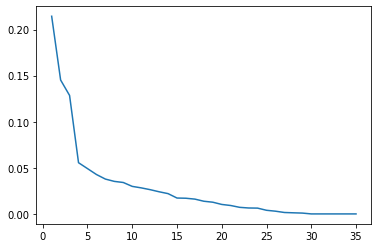

In [6]:
def plot_explained(mod):
    comps = mod.explained_variance_ratio_
    x = range(len(comps))
    x = [y + 1 for y in x]          
    plt.plot(x,comps)

plot_explained(pca_comps)

In [7]:
pca_mod_5 = skde.PCA(n_components = 5)
pca_mod_5.fit(X_train)
Comps = pca_mod_5.transform(X_train)
Comps.shape

(700, 5)

# Compute and evaluate a logistic regression model

In [8]:
## Define and fit the logistic regression model
log_mod_5 = linear_model.LogisticRegression(C = 10.0, class_weight = {0:0.45, 1:0.55}) 
log_mod_5.fit(Comps, y_train)
print(log_mod_5.intercept_)
print(log_mod_5.coef_)

[-0.7970545]
[[ 0.351739   -0.03068638 -0.41888098  0.87147247 -0.65315369]]


F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


                 Confusion matrix
                 Score positive    Score negative
Actual positive       122                90
Actual negative        17                71

Accuracy        0.64
AUC             0.76
Macro precision 0.66
Macro recall    0.69
 
           Positive      Negative
Num case      212            88
Precision    0.88          0.44
Recall       0.58          0.81
F1           0.70          0.57


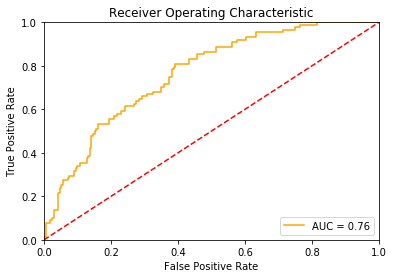

In [9]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

def print_metrics(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()    

probabilities = log_mod_5.predict_proba(pca_mod_5.transform(X_test))
print_metrics(y_test, probabilities, 0.3)    
plot_auc(y_test, probabilities)    

In [11]:
def print_format(f,x,y,z):
    print('Fold %2d    %4.3f        %4.3f      %4.3f' % (f, x, y, z))

def print_cv(scores):
    fold = [x + 1 for x in range(len(scores['test_precision_macro']))]
    print('         Precision     Recall       AUC')
    [print_format(f,x,y,z) for f,x,y,z in zip(fold, scores['test_precision_macro'], 
                                          scores['test_recall_macro'],
                                          scores['test_roc_auc'])]
    print('-' * 40)
    print('Mean       %4.3f        %4.3f      %4.3f' % 
          (np.mean(scores['test_precision_macro']), np.mean(scores['test_recall_macro']), np.mean(scores['test_roc_auc'])))  
    print('Std        %4.3f        %4.3f      %4.3f' % 
          (np.std(scores['test_precision_macro']), np.std(scores['test_recall_macro']), np.std(scores['test_roc_auc'])))
  
Labels = Labels.reshape(Labels.shape[0],)
scoring = ['precision_macro', 'recall_macro', 'roc_auc']
pca_mod = skde.PCA(n_components = 5)
pca_mod.fit(Features)
Comps = pca_mod.transform(Features)

scores = ms.cross_validate(log_mod_5, Comps, Labels, scoring=scoring,
                        cv=10, return_train_score=False)
print_cv(scores)  

         Precision     Recall       AUC
Fold  1    0.690        0.633      0.757
Fold  2    0.599        0.581      0.724
Fold  3    0.719        0.667      0.790
Fold  4    0.633        0.636      0.649
Fold  5    0.716        0.631      0.761
Fold  6    0.672        0.626      0.736
Fold  7    0.604        0.590      0.647
Fold  8    0.702        0.660      0.769
Fold  9    0.737        0.674      0.760
Fold 10    0.609        0.600      0.708
----------------------------------------
Mean       0.668        0.630      0.730
Std        0.050        0.030      0.047


F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklea

In [13]:
pca_mod_10 = skde.PCA(n_components = 10)
pca_mod_10.fit(X_train)
Comps_10 = pca_mod_10.transform(X_train)
Comps_10.shape
## define and fit the linear regression model
log_mod_10 = linear_model.LogisticRegression(C = 10.0, class_weight = {0:0.45, 1:0.55}) 
log_mod_10.fit(Comps_10, y_train)
pca_mod = skde.PCA(n_components = 10)
pca_mod.fit(Features)
Comps = pca_mod.transform(Features)

scores = ms.cross_validate(log_mod_10, Comps, Labels, scoring=scoring,
                        cv=10, return_train_score=False)
print_cv(scores)  

F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklea

         Precision     Recall       AUC
Fold  1    0.702        0.698      0.768
Fold  2    0.738        0.729      0.800
Fold  3    0.642        0.612      0.789
Fold  4    0.624        0.617      0.703
Fold  5    0.716        0.676      0.807
Fold  6    0.686        0.662      0.790
Fold  7    0.610        0.612      0.674
Fold  8    0.738        0.729      0.816
Fold  9    0.713        0.705      0.766
Fold 10    0.635        0.648      0.722
----------------------------------------
Mean       0.680        0.669      0.764
Std        0.046        0.044      0.046


F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
